In [14]:
import comet_ml
import os
import json
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ml_util.monitor.comet_ml_exp import initialize_comet_ml_experiment
from basic_transformer.models.basic_transformer import BasicTransformer
from basic_transformer import utils as local_util
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

In [2]:
MODEL_VERSION = 'x.0.0'
DATASET = 'yelp'  # 'yelp' or 'imdb'
N_SAMPLE_YELP = 50_000
TEST_SIZE = 0.2
#
N_EPOCHS = 5
DIM = 16
NUM_WORDS = 5_000
MAX_SEQ_LEN = 128
#
TEXT_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'
LABEL_MAPPING = {'negative': 0, 'positive': 1}
# dataloaders
BATCH_SIZE = 16
SHUFFLE = True
DEBUG_DF = False

# Get Data

In [3]:
if DATASET == 'yelp':
    df = pd.read_csv("/media/can/MyData/datasets/yelp/df.csv")
    df['sentiment'] = df['stars'].replace({1: 'negative', 5: 'positive'})
    df = df.rename(columns={'text': 'review'})
    df = df.sample(n=N_SAMPLE_YELP, random_state=RANDOM_SEED)
elif DATASET == 'imdb':
    df = pd.read_csv("/media/can/MyData/datasets/imdb-50k-movie-review/IMDB Dataset.csv")
else:
    raise ValueError("Invalid data: {}".format(str(DATASET)))

In [4]:
# train - test split 
df_train, df_test = train_test_split(df, test_size=TEST_SIZE)
del df
print("len(df_train):", len(df_train))
print("len(df_test):", len(df_test))

len(df_train): 40000
len(df_test): 10000


In [5]:
text_dataset_params = dict()
text_dataset_params['num_words'] = NUM_WORDS
text_dataset_params['text_column'] = TEXT_COLUMN
text_dataset_params['label_column'] = LABEL_COLUMN
text_dataset_params['label_mapping'] = LABEL_MAPPING
text_dataset_params['max_seq_len'] = MAX_SEQ_LEN

# datasets
datagen_train = local_util.dataset_generator.TextDataset(df=df_train, **text_dataset_params)
datagen_test = local_util.dataset_generator.TextDataset(df_test, 
                                                        **text_dataset_params, 
                                                        tokenizer=datagen_train.tokenizer)

In [6]:
dataloader_params = dict()
dataloader_params['batch_size'] = BATCH_SIZE
dataloader_params['num_workers'] = multiprocessing.cpu_count()
dataloader_params['shuffle'] = SHUFFLE

# dataloaders
dataloader_train = DataLoader(dataset=datagen_train, **dataloader_params)
dataloader_test = DataLoader(dataset=datagen_test, **dataloader_params)

# Train

In [7]:
# get model
model = BasicTransformer(dim=DIM, num_embeddings=NUM_WORDS, embedding_dim=DIM)

In [8]:
model.cuda()

BasicTransformer(
  (embed_layer): Embedding(5001, 16)
  (linear): Linear(in_features=16, out_features=16, bias=True)
  (linear_clf): Linear(in_features=16, out_features=1, bias=True)
)

In [9]:
# loss and optimizer
criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters())

In [10]:
# initialize comet experiment
COMET_ML_EXPERIMENT, \
COMET_ML_EXPERIMENT_LINK = initialize_comet_ml_experiment(model_name=local_util.config.PROJECT_NAME, 
                                                          model_version=MODEL_VERSION)

COMET INFO: old comet version (2.0.11) detected. current: 2.0.14 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/a-c-ozbek/basic-transformer-clf-from-scratch/5957c686505c451e93462779705745be

/home/can/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/can/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)








Test Accuracy: 0.9085000000000012

miniyolo  yelp


In [11]:
epoch_loss = local_util.math.AvgContainer()
epoch_acc = local_util.math.AvgContainer()

with COMET_ML_EXPERIMENT.train():
    for epoch in range(N_EPOCHS):
        p_bar = tqdm_notebook(enumerate(dataloader_train), total=len(dataloader_train))
        for i, x in p_bar:
            
            inputs = x['seq']
            labels = x['label'].float()

            inputs = inputs.cuda()
            labels = labels.cuda()

            #
            optimizer.zero_grad()

            # 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # acc
            y_true = labels.cpu().numpy().astype(np.int)
            y_pred = (outputs > 0.5).cpu().numpy().astype(np.int).squeeze()
            acc = np.mean(y_true == y_pred)
            
            # log
            COMET_ML_EXPERIMENT.log_metric("batch_loss", loss)
            COMET_ML_EXPERIMENT.log_metric("batch_acc", acc)
            
            # update avg
            epoch_loss.update([loss.item()])
            epoch_acc.update([acc])
            p_bar.set_description("Epoch: {} - Loss: {} - Acc: {}".format(str(epoch + 1),
                                                                          "{0:.3f}".format(epoch_loss.avg), 
                                                                          "{0:.3f}".format(epoch_acc.avg)))
        
        # log
        COMET_ML_EXPERIMENT.log_metric("epoch_loss", epoch_loss.avg, step=epoch)
        COMET_ML_EXPERIMENT.log_metric("epoch_acc", epoch_acc.avg, step=epoch)
        
        # reset
        epoch_loss.reset()
        epoch_acc.reset()

# Test

In [12]:
test_acc = local_util.math.AvgContainer()
acc_values = list()
loss_values = list()
y_true_list = list()
y_pred_list = list()
with COMET_ML_EXPERIMENT.test():
    for i, x in tqdm_notebook(enumerate(dataloader_test), total=len(dataloader_test)):
        inputs = x['seq']
        labels = x['label'].float()

        inputs = inputs.cuda()
        labels = labels.cuda()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss_values.append(loss)
        
        #
        y_true = labels.cpu().numpy().astype(np.int)
        y_pred = (outputs > 0.5).cpu().numpy().astype(np.int).squeeze()
        acc = np.mean(y_true == y_pred)
        acc_values.append(acc)
        
        test_acc.update([acc])
        
        # save 
        y_true_list += list(y_true)
        y_pred_list += list(y_pred)

print("Test Accuracy:", test_acc.avg)

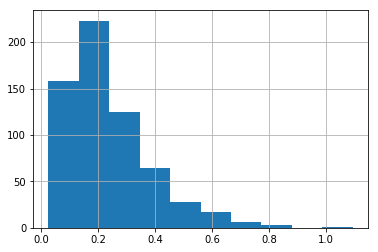

In [13]:
# loss values
loss_values_ = [l.item() for l in tqdm_notebook(loss_values)]
pd.Series(loss_values_).hist()

In [17]:
# confusion matrix
confusion_matrix(y_true_list, y_pred_list)

array([[4633,  408],
       [ 507, 4452]])

# Save Model

In [25]:
path_to_save = os.path.join("/media/can/MyData/models/", local_util.config.PROJECT_NAME, "model.pth")
torch.save(model.state_dict(), path_to_save)